# Working with multi-dimensional image data
---
This notebook explores a few uses of multi-dimensional datasets made avaialable through ArcGIS Online. Here, we explore the Sea Surface Temperature (SST) dataset [link](https://www.arcgis.com/home/item.html?id=100a26c4d15445ffadab0d04e536b9c1). This dataset contains daily SST values from 1985 to the present at a 0.05° (~5km) resolution across all ocean surfaces.  

The exact procedures and operations covered include:

* Setting up the coding session for accessing and querying multi-dimensional data
* Reading the multi-dimensional into the coding session
* Exploring properties of the dataset
* Extracting values at specific locations and times
* Creating a time series dataset for one or several points

What's not covered here yet (as our Organization AGOL subscription does not cover) includes: 
* Creating mosaic layers from the multi-dimensional data, i.e., aggregating data across time slices
---
Fall 2024  
John.Fay@duke.edu

---


## 1. Setting up the coding environment
ESRI's ArcGIS API for Python provides the functionality for working with these multi-dimensional rasters. We need to import a few sub-modules, including the `GIS` sub-module which we use to authenticate to Duke's AGOL Organizational account. 

In [1]:
#Import packages
from arcgis import GIS
from arcgis.raster import ImageryLayer, Raster
from arcgis.geometry import Point, filters
from datetime import datetime, timedelta

#Connect to GIS via ArcGIS Pro
gis = GIS("home")

## 2. Accessing and exploring  the SST raster dataset
We can access AGOL datsets many different way: indirectly by searching for it, or directly either from its item ID or its URL. We'll explore each here, and then explore some properties of the dataset. 



### 2.1 Accessing the data by searching for it
Documentation on the `gis.content.search()` function [here](https://developers.arcgis.com/python/latest/api-reference/arcgis.gis.toc.html#arcgis.gis.ContentManager).  

First, we search and examine the results. Then, we extract the result we want and view its item page to confirm. 

In [2]:
#Search for the SST layer
search_result = gis.content.search(
    query="SST owner:esri", 
    outside_org=True,
    item_type="Imagery Layer")
#Reveal the results
search_result

[<Item title:"Sea Surface Temperature (C) (Mature Support)" type:Imagery Layer owner:esri>,
 <Item title:"Arctic Sea Surface Temperature (C) (Mature Support)" type:Imagery Layer owner:esri>,
 <Item title:"Sea Surface Temperature (SST)" type:Imagery Layer owner:esri>,
 <Item title:"Sea Surface Temperature Anomaly (SSTA)" type:Imagery Layer owner:esri>]

<Item title:"Sea Surface Temperature (SST)" type:Imagery Layer owner:esri>
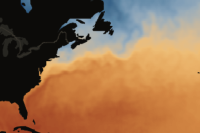

In [4]:
#Extract the 3rd item from the search results
sst_item = search_result[2]
sst_item

The `sst_item` obejct we created is a container for the data, not the imagery layer dataset itself. To get that, we need to list the layers contained in this item and fetch the appropritate one. 

In [5]:
#List the layers in the SST item
sst_layers = sst_item.layers
sst_layers

[<ImageryLayer url:"https://oceans5.arcgis.com/arcgis/rest/services/SST/ImageServer">]

In [6]:
#Fetch the one (and only) layer in the SST item and reveal its type
sst_layer = sst_layers[0]
type(sst_layer)

arcgis.raster._layer.ImageryLayer

That's the object we want! Before working with it, let's look at some other ways we can get to this object...

### 2.2 Accessing the dataset directly

#### ...Via the item ID
If you open the above link, you'll see it's item ID in the url: `100a26c4d15445ffadab0d04e536b9c1`. You'll also see it in the page itself, midway down on the righthand side. We can use this item ID to access the dataset directly. We do this using the [`gis.content.get()`](https://developers.arcgis.com/python/latest/api-reference/arcgis.gis.toc.html#arcgis.gis.ContentManager.get) command. 

<Item title:"Sea Surface Temperature (SST)" type:Imagery Layer owner:esri>
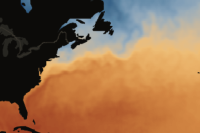

In [7]:
sst_item = gis.content.get('100a26c4d15445ffadab0d04e536b9c1')
sst_item

Bingo! Now we can use the methods above to get to the SST layer itself.

In [8]:
#Fetch the first layer in the SST item
sst_layer = sst_item.layers[0]
type(sst_layer)

arcgis.raster._layer.ImageryLayer

#### ...Via the layer's service URL
Going back to the [item page](https://dukeuniv.maps.arcgis.com/home/item.html?id=100a26c4d15445ffadab0d04e536b9c1) for the SST data layer, you'll see a link to the URL for the service toward the bottom of the page on the right hand side:  
<https://oceans5.arcgis.com/arcgis/rest/services/SST/ImageServer>

In addition to seeing the properties for this image layer service on this page, we can use it to access the resource directly as an ImageryLayer object.  
(Doing this requires importing the `ImageryLayer` class from the `arcgis.raster` submodule.)

In [8]:
#Create the ImageryLayer object for the SST layer directly from its service URL
sst_layer = ImageryLayer('https://oceans5.arcgis.com/arcgis/rest/services/SST/ImageServer')
type(sst_layer)

arcgis.raster._layer.ImageryLayer

### 2.3 Exploring properties of the imagery layer
Let's move on to examining properties we'll need to work with the dataset. `sst_layer` is an ImageryLayer object and we can examine documentation on that type of object [here](https://developers.arcgis.com/python/latest/api-reference/arcgis.raster.toc.html#imagerylayer). 

Specifically, we'll confirm that our ImageryLayer is multi-dimensional, and then extract its multi-dimensional properties. 

In [9]:
#Confirm the SST layer has multidimensions
sst_layer.properties.hasMultidimensions

True

Multi-dimensional data are comprised of variables and dimensions. 
* **Variables** represent the actual data values or measurements stored in the multidimensional raster. 
* **Dimensions** define the structure and organization of the data.

To reveal the dimensions in our ImageryLayer, it's easier to first convert it to a Raster object; rather, we create a raster object from the same URL from which the ImageryLayer is derived.  

That Raster object then has functions to reveal the variables contained, and the dimensions of each variable. 

In [ ]:
#Convert the SST layer to a multidimensional raster object
sst_raster = Raster(sst_layer.url,is_multidimensional=True)

#Reveal the variables in the SST raster
sst_raster.variable_names

['alert', 'sst', 'ssta']

We see that the dataset has three variables: 
* `alert` - Coral bleaching heat stress alert level
* `sst` - Sea Surface Temperature
* `ssta` - Sea Surface Temperature Anomalies
>Source for what these variables represent: <https://coralreefwatch.noaa.gov/product/5km/index_5km_baa-max-7d.php>

The one we want is the second: `sst`. Now we can examine the dimensions associated with that variable. 

In [103]:
#Reveal the dimensions in the SST raster's 'sst' variable
sst_raster.get_dimension_names('sst')

['StdTime']

Just the one dimension: `StdTime`, which is the time dimension. Next, let's look at the attributes and some values in the time dimension of the sst variable

In [107]:
#Get attributes for the 'StdTime' dimension in the SST raster
sst_raster.get_dimension_attributes(variable_name='sst', dimension_name='StdTime')

{'Interval': 1,
 'IntervalUnit': 'Days',
 'HasRegularIntervals': True,
 'HasRanges': False,
 'Minimum': '1985-01-01T12:00:00+00:00',
 'Maximum': '2024-10-15T12:00:00+00:00',
 'Unit': '',
 'Description': ''}

In [111]:
#Take a peek at the first 5 time values in the SST raster
time_values = sst_raster.get_dimension_values(variable_name='sst', dimension_name='StdTime')
print(len(time_values))
time_values[0:5]

14533


['1985-01-01T12:00:00+00:00',
 '1985-01-02T12:00:00+00:00',
 '1985-01-03T12:00:00+00:00',
 '1985-01-04T12:00:00+00:00',
 '1985-01-05T12:00:00+00:00']

##### Recapping what we just learned: 
* The multi-dimension SST ImageryLayer has quite a lot of data! 
* The layer contains three separate variables: alert levels, sst, and sst anomalies
* The sst variable (as well as the other two) have measurements recorded across a time dimension ("StdTime")
* This time dimension contains daily SST measurements from 1985 to the present, over 14,000 records (for ever 5 square km of ocean surface)

##### And moving forward, we want to tap into this massive dataset in two ways: 
* Extract a single SST value at a define location and time
* Extract a time series of SST values at a define location or set of locations

---

## 3. Extracting data

### 3.1 Extract sea surface temperature at a given location for a given time
The [`identify()`](https://developers.arcgis.com/python/latest/api-reference/arcgis.raster.toc.html#arcgis.raster.ImageryLayer.identify) function of an ImageryLayer allows us to extract values from a multidimensional image for a provided a spatial and temporal extent (e.g. a point and a start & end times). To do this, we first need create a **Point object** and specifiy the start and end times as a **datetime** object, so that we can pass these as input parameters into the `identify()` function. 



#### Creating the Point object
In the first code cell, we import the `Point` class from the `arcgis.geometry` submodule. Documentation on this class is [here](https://developers.arcgis.com/python/latest/api-reference/arcgis.geometry.html#point), with the code involved in creating a point (and other geometries) found in [this tutorial](https://developers.arcgis.com/python/latest/guide/tutorials/add-a-point-line-and-polygon/).

Below, we'll create a point from lat and lng variables, specifying the spatial reference as well. 

In [112]:
#Start by setting the coordinate of our point
lat = 35.402234
lng = -74.4840627

#Create a point, using the lat and lng coordinates and the spatial reference of WGS84
the_point = Point({
    "x" : lng, 
    "y" : lat, 
    "spatialReference" : {"wkid" : 4326}
    })

#Show the type of our point
type(the_point)

arcgis.geometry._types.Point

In [53]:
#OPTIONAL: View the point on a map
map1 = gis.map(
    location=tuple(the_point.coordinates()[::-1]), #Switch the order of the coordinates
    zoomlevel=8
)
map1.draw(the_point)
#map1

#### Creating the time slice
We use Python's `datetime` class, from of the `datetime` module, to create the start and end times for our `identify()` tool. We can either explicitly set both times, or set the start time and specify the end time as a period of time ("timedelta") after the start time. 

Recalling that our SST data records sea surface temperature daily, we'll set the start as June 21, 2010 and the end as the following day - June 22, 2010.

In [113]:
#Create datetime objects for the start and end dates
start_date = datetime(2010, 6, 21)
end_date = datetime(2020, 6, 22)

#or we can set the end date as the start date plus a "timedelta" of 1 day
end_date = start_date + timedelta(days=1)

#Show the dates
print(start_date, end_date)

2010-06-21 00:00:00 2010-06-22 00:00:00


#### Running the `identify()` tool
We now have the ingredients to run the `identify()` tool: the **geometry** (our point), the **time_extent** (our start & end times), and of course our SST imagery layer. We also need to specify that our imagery layer is multidimensional. 

In [80]:
#Identify the SST values at the point for the specified time extent
sst_result = sst_layer.identify(
    geometry=the_point,
    time_extent=[datetime(2010,1,1),datetime(2010,1,2)],
    process_as_multidimensional=True,
)

#Reveal the result
sst_result

{'objectId': 0,
 'name': 'Pixel',
 'value': '0; 23.38; 3.47',
 'location': {'x': -74.4840627,
  'y': 35.402234,
  'spatialReference': {'wkid': 4326, 'latestWkid': 4326}},
 'properties': {'Attributes': [{'Variable': 'alert',
    'StdTime': 1262347200000,
    'StdTime_Max': 1262347200000},
   {'Variable': 'sst', 'StdTime': 1262347200000, 'StdTime_Max': 1262347200000},
   {'Variable': 'ssta',
    'StdTime': 1262347200000,
    'StdTime_Max': 1262347200000}]},
 'catalogItems': None,
 'catalogItemVisibilities': []}

#### Interpreting the result
We see that the result is a dictionary. This dictionary includes values for each of the three variables, among some other information that may or may not be useful to us. Anyway, we can use our Python dictionary skills to pull out the value we want: the second item in the list associated with the `value` key (converted to a floating point number).

In [125]:
#Fetch the SST value at the point
the_sst = float(sst_result['value'].split('; ')[1])

#Report the SST value
print(f'At the point ({lat}, {lng}) on {start_date} the SST was {the_sst} degrees Celsius')

At the point (35.402234, -74.4840627) on 2010-06-21 00:00:00 the SST was 23.38 degrees Celsius


### 3.2 Create a time series plot
With knowledge of the structure of our dataset, we can run some other data extraction/visualization tools as well. Here we look at the `temporal_profile()` function that generates a nice line plot of our variable at a location, or multiple locations, as well as a trendline.

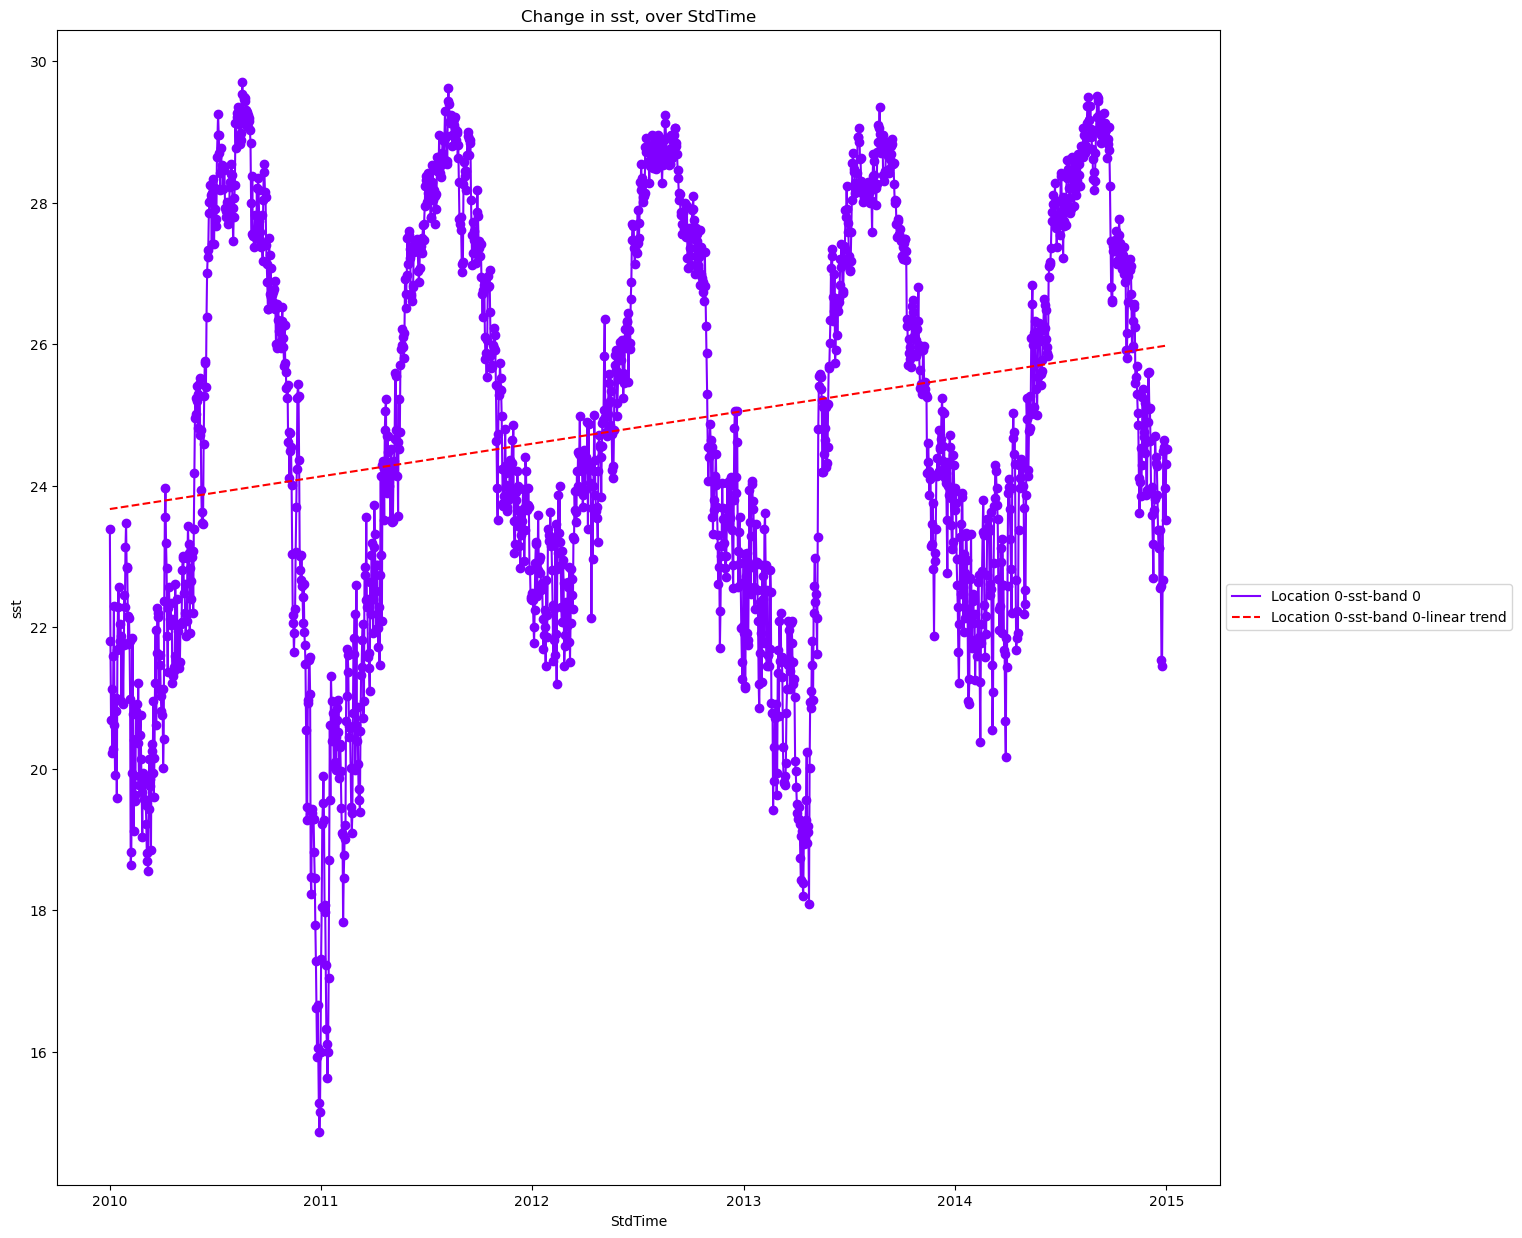

In [ ]:
sst_layer.temporal_profile(
    points=[the_point], 
    time_field='StdTime',
    variables=['sst'],
    time_extent=[datetime(2010,1,1),datetime(2015,1,2)],
    trend_type='linear'
)

## Temporal Averaging
If we had access to an AGOL server capable of raster analysis, we could aggregate values over time. The code would look like this.

In [ ]:
#Import the 'aggregate_multidimensional_raster' function
from arcgis.raster.analytics import aggregate_multidimensional_raster

#Aggregate the SST raster to monthly intervals
agg_raster = aggregate_multidimensional_raster(
    input_multidimensional_raster=sst_raster, 
    dimension='StdTime', 
    variables=['sst'], 
    aggregation_method='MEAN', 
    aggregation_definition='ALL', 
    interval_keyword='MONTHLY', 
    gis=gis
)